In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

Importing Data


In [16]:
#Importing data
#dataset = pd.read_excel("~/Desktop/venv/bin/t_input_data.xlsx")
dataset = pd.read_csv("[valuation]_complete_input.csv")

#Call to get FQ: 
#dataframe_all_quarters["FQ42021"]

for column in dataset.columns:
    dataset = dataset.dropna(subset=[column], how='all', axis=0, inplace=False)
    dataset = dataset.replace([np.inf, -np.inf], np.nan)
    dataset = dataset.dropna(subset=[column], axis=0, inplace=False)

In [17]:
dataset.columns

Index(['Unnamed: 0', 'FQYear', 'Beta', 'Entity Name ', 'Entity ID ',
       'Cash and Cash Equivalents ($000)', 'EBIT ($000)', 'EBITDA ($000)',
       'Net Debt ($000)', 'Net Income ($000)', 'Total Assets ($000)',
       'Total Debt ($000)', 'Total Liabilities ($000)', 'Total Revenue ($000)',
       'Primary Industry ', '1st Level Primary Industry ',
       '2nd Level Primary Industry ', 'Exchange ', 'Global Region ',
       'Market Cap', 'EBIT margin', 'EBITDA margin', 'Profit margin',
       'Debt-to-assets', 'Leverage', 'Cash-to-assets', 'Enterprise value',
       'EV/Sales', 'EV/EBIT', 'EV/EBITDA', 'P/E'],
      dtype='object')

Splitting Data into Quarterly Dataframes

In [18]:
# Split the data into several dataframes for each corresponding FQ
quarters = dataset["FQYear"].unique()
dataframe_all_quarters = {}
for quarter in quarters:
    dataframe_one_quarter = dataset[dataset['FQYear'] == quarter]
    dataframe_all_quarters[quarter] = dataframe_one_quarter
    

# Encoding the data
label_encoder = LabelEncoder()

# Columns to encode
columns_to_encode = ['Primary Industry ', '1st Level Primary Industry ', '2nd Level Primary Industry ', 'Global Region ']

encoded_dataframe_all_quarters = {}
# Encoding every df
for quarter, df in dataframe_all_quarters.items():
    # Apply label encoding to the columns
    quarter_copy = df.copy()
    for column in columns_to_encode:
        # quarter_copy.loc[:, column] = label_encoder.fit_transform(quarter_copy[column])       (older python version)
        quarter_copy[column] = label_encoder.fit_transform(quarter_copy[column])
        
    # Updating new dictionary with encoded dataframe
    encoded_dataframe_all_quarters[quarter] = quarter_copy

## First Clustering: Based on Industry

In [19]:
# Select the columns to use for clustering
'''
'Unnamed: 0.1', 'Unnamed: 0', 'FQYear', 'Beta', 'Entity Name ', 'Entity ID ',
       'Cash and Cash Equivalents ($000)', 'EBIT ($000)', 'EBITDA ($000)',
       'Net Debt ($000)', 'Net Income ($000)', 'Total Assets ($000)',
       'Total Debt ($000)', 'Total Liabilities ($000)', 'Total Revenue ($000)',
       'Primary Industry ', '1st Level Primary Industry ',
       '2nd Level Primary Industry ', 'Exchange ', 'Global Region ',
       'Market Cap', 'EBIT margin', 'EBITDA margin', 'Profit margin',
       'Debt-to-assets', 'Leverage', 'Cash-to-assets', 'Enterprise value',
       'EV/Sales', 'EV/EBIT', 'EV/EBITDA', 'P/E']
'''

columns_to_cluster = ['Beta', 'EBITDA margin','Total Assets ($000)','Total Revenue ($000)','Primary Industry ','Global Region ', 'Debt-to-assets', 'Cash-to-assets',
       'Enterprise value', 'EV/Sales', 'EV/EBITDA', 'P/E']  # Add more columns if needed

cluster_dataframes = {}

# For every FQ
for quarter in encoded_dataframe_all_quarters:
    
    # First clustering based on Industry
    # Subset the dataframe with the selected columns
    clustering_input = encoded_dataframe_all_quarters[quarter][columns_to_cluster]

    # Apply weights to the data, This chan be changed
    weights = [0.00, 0.00, 0.0, 0.0, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

    # Calculate the pairwise distances between data points
    distances = pdist(clustering_input, metric='euclidean', w=weights) # weighted

    # Perform hierarchical clustering using Ward linkage method
    linkage_matrix = linkage(distances, method='ward')

    # In the first run, only 165 Clusters will be done since the weight is 100% on Primary Industry, which was 165 unique values
    max_cluster_size = 500
    cluster_labels = fcluster(linkage_matrix, max_cluster_size, criterion='maxclust')

    # Assign the cluster labels to the DataFrame
    encoded_dataframe_all_quarters[quarter]['Industry Cluster'] = cluster_labels

    # Print resulting clusters
    grouped_encoded_dataframe = encoded_dataframe_all_quarters[quarter].groupby('Industry Cluster')

    # Iterate over each group and print the companies
    for cluster_id, group in grouped_encoded_dataframe:
        companies = group['Entity Name '].tolist()
        print(f"Companies in Cluster '{cluster_id}': {', '.join(companies)}")

    cluster_counts = pd.Series(cluster_labels).value_counts()
    largest_cluster_size = cluster_counts.max()
    smallest_cluster_size = cluster_counts.min()
    avg_cluster_size = cluster_counts.mean()

    unique_clusters = encoded_dataframe_all_quarters[quarter]['Industry Cluster'].unique()

    clusters_one_quarter = {}
    
    # Iterate over each cluster label
    for cluster_label in unique_clusters:
        # Filter the original DataFrame based on the cluster label
        cluster_data = encoded_dataframe_all_quarters[quarter][encoded_dataframe_all_quarters[quarter]['Industry Cluster'] == cluster_label].copy()
        
        # Assign the filtered data to the current cluster label
        clusters_one_quarter[cluster_label] = cluster_data
    
    # Assign the clusters for the current quarter to the overall cluster_dataframes dictionary
    cluster_dataframes[quarter] = clusters_one_quarter
    
    # To access cluster c from quarter fq:
    # cluster_dataframes['fq'][c]

    cluster_counts = pd.Series(cluster_labels).value_counts()
    largest_cluster_size = cluster_counts.max()
    largest_cluster_index = cluster_counts.idxmax()
    smallest_cluster_size = cluster_counts.min()
    avg_cluster_size = cluster_counts.mean()

    print("Size of the largest cluster:", largest_cluster_size)
    print("Index of the largest cluster:", largest_cluster_index)
    print("Size of the smallest cluster:", smallest_cluster_size)
    print("Size of the average cluster:", avg_cluster_size)
    print("Number of clusters:", len(cluster_counts))

print("")
print("Primary Clustering done")

Companies in Cluster '1': AmerisourceBergen Corporation (NYSE:ABC), AS ONE Corporation (TSE:7476), China Meheco Group Co., Ltd. (SHSE:600056), Henry Schein, Inc. (NASDAQGS:HSIC), Japan Medical Dynamic Marketing, INC. (TSE:7600), McKesson Corporation (NYSE:MCK), MediPal Holdings Corporation (TSE:7459), Muller & Phipps (Ceylon) PLC (COSE:MULL.N0000), Owens & Minor, Inc. (NYSE:OMI), Patterson Companies, Inc. (NASDAQGS:PDCO), Pharmaniaga Berhad (KLSE:PHARMA), SALUS, Ljubljana, d. d. (LJSE:SALR), Tai United Holdings Limited (SEHK:718), Toho Holdings Co., Ltd. (TSE:8129)
Companies in Cluster '2': Antilles Gold Limited (ASX:AAU), Apex Mining Co., Inc. (PSE:APX), Chugai Mining Co., Ltd. (TSE:1491), Coeur Mining, Inc. (NYSE:CDE), DRDGOLD Limited (NYSE:DRD), Eldorado Gold Corporation (TSX:ELD), Gold Fields Limited (JSE:GFI), Harmony Gold Mining Company Limited (JSE:HAR), Kinross Gold Corporation (TSX:K), Lepanto Consolidated Mining Company (PSE:LCB), Newcrest Mining Limited (ASX:NCM), Orvana Min

"Binary Clustering" 

## Further clustering for other variables

In [ ]:
cluster_dataframes_final = {}
for quarter in encoded_dataframe_all_quarters:
    print("CURRENTLY CLUSTERING QUARTER: ", quarter)

    for i in range(1, len(cluster_dataframes[quarter])): # i for Industry Based Cluster
        print("CURRENTLY CLUSTERING INDUSTRY: ", i)

        # The Peer Group is too big: Value in second last and last column is the same, and there are more than 15 occurrences of the value in the last column (the last column is also the last "run of clustering")
        while (any(cluster_dataframes[quarter][i].iloc[:, -1].value_counts() > 15)):
                
                dataframe = cluster_dataframes[quarter][i]
                dataframe_2 = dataframe.copy()
                print("here")
            
                values_to_iterate = dataframe.iloc[:,-1].dropna().unique().tolist()
                print("VALUES TO CONSIDER:", values_to_iterate)
                
                #while(values_to_iterate):
                for value in dataframe.iloc[:,-1].dropna().unique().tolist():

                    #value = values_to_iterate.pop(0)

                    run = 1;
                    print("Now looking at: " , value, " in row", dataframe.columns[-1])
                    
                    # If Subset of Cluster is only one company - no distances can be calculated!  
                    if (len(dataframe[dataframe.iloc[:,-1] == value]) < 2):
                        print("FQ: ", quarter,"Peer group ", i,"is too small: Only" , len(dataframe[dataframe.iloc[:, -1] == value]) , "companies in this group")
                        print("not breaking")
                    
                    else:

                        if (len(dataframe[dataframe.iloc[:, -1] == value]) > 15):
                        
                            previous_cluster_index = dataframe.columns[-1][-1]

                            # THIS DOESN'T WORK ANYMORE
                            #sub_cluster_name = "Subcluster " + str(int(dataframe.columns[-1][-1]) + 1) if (dataframe.columns[-1][-1]).isdigit() else "Subcluster 1"

                            print("NOW SPLITTING UP: FQ", quarter, " cluster", i, " on value ", value, "// ", len(dataframe[dataframe.iloc[:, -1] == value]) , "companies in this group")

                            # Select the columns to use for clustering
                            columns_to_cluster = ['Beta', 'EBITDA margin','Total Assets ($000)','Total Revenue ($000)','Global Region ', 'Debt-to-assets', 'Cash-to-assets',
                            'Enterprise value', 'EV/Sales', 'EV/EBITDA', 'P/E']  # Add more columns if needed

                            # Subset the dataframe with the selected columns: Only the selected rows which are from same cluster (saved in last column)
                            cluster_input = dataframe[dataframe.iloc[:, -1] == value][columns_to_cluster]

                            # Indices (for later on to paste right cluster labels)
                            indices = dataframe[dataframe.iloc[:, -1] == value].index
                            if (len(indices) == 1):
                                # This is some bug fixing i encountered
                                print("breaking")
                                break;

                            # Weights on the input parameters
                            weights = [len(columns_to_cluster)/100] * 11
                            
                            k = 2  # Number of clusters
                            kmeans = KMeans(n_clusters=k,n_init=10)

                            weighted_cluster_input = cluster_input * weights

                            # Fit the weighted K-means model
                            kmeans.fit(weighted_cluster_input)

                            # Get the cluster assignments
                            cluster_labels = kmeans.labels_
                            
                            cluster_stack = cluster_labels.tolist()
                            k = 0;

                            while(cluster_stack):
                                #value = cluster_stack.pop(0)
                                #row_index = dataframe.loc[dataframe.iloc[:, -1] == value].index[k]
                                #dataframe.loc[dataframe.iloc[:, -1] == value, sub_cluster_name].at[row_index, sub_cluster_name] = value
                                #k += 1
                                values = cluster_stack.pop(0)
                                row_index = indices[k]

                                # THIS NEEDS TO BE CHANGED
                                # dataframe_2.iloc[row_index,-1] = values

                                old_subcluster = str(dataframe.loc[row_index,dataframe.columns[-1]])
                                new_subcluster = old_subcluster + "." + str(values)
                                dataframe_2.at[row_index, dataframe_2.columns[-1]] = new_subcluster
                                k += 1

                            print("Splitting ", quarter, " ", i, "done: ", len(dataframe[dataframe.iloc[:, -1] == value]))
                            
                            run += 1;
                
                print("here after break")
                cluster_dataframes[quarter][i] = dataframe_2;
                
print("")           
print("Clustering done")

CURRENTLY CLUSTERING QUARTER:  FQ42021
CURRENTLY CLUSTERING INDUSTRY:  1
CURRENTLY CLUSTERING INDUSTRY:  2
here
VALUES TO CONSIDER: [2]
Now looking at:  2  in row Industry Cluster
NOW SPLITTING UP: FQ FQ42021  cluster 2  on value  2 //  19 companies in this group
Splitting  FQ42021   2 done:  19
here after break
here
VALUES TO CONSIDER: ['2.0', '2.1']
Now looking at:  2.0  in row Industry Cluster
NOW SPLITTING UP: FQ FQ42021  cluster 2  on value  2.0 //  16 companies in this group
Splitting  FQ42021   2 done:  16
Now looking at:  2.1  in row Industry Cluster
here after break
CURRENTLY CLUSTERING INDUSTRY:  3
here
VALUES TO CONSIDER: [3]
Now looking at:  3  in row Industry Cluster
NOW SPLITTING UP: FQ FQ42021  cluster 3  on value  3 //  33 companies in this group
Splitting  FQ42021   3 done:  33
here after break
here
VALUES TO CONSIDER: ['3.1', '3.0']
Now looking at:  3.1  in row Industry Cluster
Now looking at:  3.0  in row Industry Cluster
NOW SPLITTING UP: FQ FQ42021  cluster 3  on v

## Output

In [25]:
# To get results:

#cluster_dataframes[quarter][i] 
#quarter = FQ
#i = Industry Based Cluster

cluster_dataframes["FQ12019"][1]["Primary Industry "]



# I am also currently working to output the result in the scheme of the following df:
# cluster_dataframe_company_x

# QUARTER       PEER GROUP (Entity IDs)
# FQ1...            ...
# FQ2...            ...
# FQ3...            ...
# ...               ...

2971     60
4171     60
11651    60
27451    60
32151    60
40891    60
40971    60
43611    60
49191    60
50291    60
50971    60
57491    60
65751    60
70351    60
Name: Primary Industry , dtype: int32

In [26]:
# WORKING ON THE OUTPUT METHOD

grouped_dfs = {}

for quarter in cluster_dataframes:
    dataframes = []
    for i in range(1, 165):
        dataframes.append(cluster_dataframes[quarter][i])
    concatenated_df = pd.concat(dataframes)
    grouped_df = concatenated_df.groupby("Industry Cluster", dropna=False)
    
    unique_groups = grouped_df.groups.keys()
    grouped_dfs[quarter] = {}
    
    for group_name in unique_groups:
        grouped_dfs[quarter][group_name] = grouped_df.get_group(group_name)

# To get all the companies in a cluster:
# grouped_dfs[quarter][cluster_name]
grouped_dfs["FQ12020"]

# All cluster groups:
unique_groups

grouped_dfs["FQ12020"]

quarter = "FQ12020"
for i in range(1, 165):
    dataframes.append(cluster_dataframes[quarter][i])
    concatenated_df = pd.concat(dataframes)
    grouped_df = concatenated_df.groupby("Industry Cluster", dropna=False)
    

In [543]:
peer_groups_every_quarter = {}
# Create a new DataFrame that has the entity name in one column and all companies in the same group in the other column
for quarter in grouped_dfs:
    df_list = []

    # Group all companies from one cluster
    for group in grouped_dfs[quarter]:
        new_rows = pd.DataFrame({"Entity ID ": grouped_dfs[quarter][group]["Entity ID "].tolist(), "Group": group})
        df_list.append(new_rows)

    # Concatenate and add as new column
    temporary_dataframe = pd.concat(df_list, ignore_index=True)
    peer_groups_every_quarter[quarter] = temporary_dataframe.groupby("Group")["Entity ID "].apply(list).reset_index()

# To get all the groups and companies for a quarter:
# df_new[quarter]:
peer_groups_every_quarter["FQ22017"]

TypeError: unhashable type: 'list'

In [27]:
peer_groups_every_quarter = {}

# Create a new DataFrame that has the entity name in one column and all companies in the same group in the other column
for quarter in grouped_dfs:
    df_list = []

    # Group all companies from one cluster
    for group in grouped_dfs[quarter]:
        new_rows = pd.DataFrame({"Entity ID ": grouped_dfs[quarter][group]["Entity ID "].tolist(), "Group": group})
        df_list.append(new_rows)

    # Concatenate and add as new column
    temporary_dataframe = pd.concat(df_list, ignore_index=True)
    peer_groups_every_quarter[quarter] = temporary_dataframe.groupby("Group")["Entity ID "].apply(list).reset_index()

# To get all the groups and companies for a quarter:
# peer_groups_every_quarter[quarter]


In [28]:
# To get the peer group for a company for a certain quarter:
def find_peer_group(entity_id, quarter):
        df = peer_groups_every_quarter[quarter]
        for row in range(0, len(df)):
            if entity_id in df.iloc[row, 1]:
                return df.iloc[row,1]
                #print("Quarter: ", quarter, "      Peer Group:", df.iloc[row,1])


# For example: (entity_id of company to look for)
find_peer_group(4161767,"FQ12019")

[4161767.0, 4237911.0, 4054841.0, 4069352.0, 4916719.0, 4087448.0, 4004136.0]

In [29]:
# To get the average multiple for ever quarter of a certain company
def get_multiples(entity_id):
    for quarter in grouped_dfs:
        # print(find_peer_group(entity_id,quarter))
        peer_group = find_peer_group(entity_id,quarter)

        # List of all multiples
        list_of_multiples = []

        # Get multiple for each company:
        for company in peer_group:
            
            multiple = dataframe_all_quarters[quarter][dataframe_all_quarters[quarter]["Entity ID "] == company]["EV/EBITDA"].values[0]

            # This is to look into where the multiples are coming from
            #print("Quarter:  ", quarter, "Company:", company, "Multiple: ", multiple)
            list_of_multiples.append(multiple)
        
        print("Quarter: ", quarter, "   Average EV-EBIT Multiple:  " ,round(np.median(list_of_multiples),2))

# get_multiples(4161767) This number is making some troubles as there is a year with 8372
get_multiples(4812242)

Quarter:  FQ42021    Average EV-EBIT Multiple:   39.32
Quarter:  FQ32021    Average EV-EBIT Multiple:   51.42
Quarter:  FQ22021    Average EV-EBIT Multiple:   37.8
Quarter:  FQ12021    Average EV-EBIT Multiple:   34.55
Quarter:  FQ42020    Average EV-EBIT Multiple:   26.95
Quarter:  FQ32020    Average EV-EBIT Multiple:   41.34
Quarter:  FQ22020    Average EV-EBIT Multiple:   20.07
Quarter:  FQ12020    Average EV-EBIT Multiple:   54.1
Quarter:  FQ42019    Average EV-EBIT Multiple:   45.83
Quarter:  FQ32019    Average EV-EBIT Multiple:   45.58
Quarter:  FQ22019    Average EV-EBIT Multiple:   40.51
Quarter:  FQ12019    Average EV-EBIT Multiple:   53.2
Quarter:  FQ42018    Average EV-EBIT Multiple:   38.18
Quarter:  FQ32018    Average EV-EBIT Multiple:   54.91
Quarter:  FQ22018    Average EV-EBIT Multiple:   39.4
Quarter:  FQ12018    Average EV-EBIT Multiple:   54.41
Quarter:  FQ42017    Average EV-EBIT Multiple:   36.06
Quarter:  FQ32017    Average EV-EBIT Multiple:   45.08
Quarter:  FQ22

In [35]:
increments = []
for i in range(0,105,5):
    increments.append(i/100)
    
increments

[0.0,
 0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95,
 1.0]

In [37]:
dataframe_new["implied_shareprice_EV/EBIT"] = (dataframe_new["EV/EBIT AVG"] * dataframe_new["EBIT"] - dataframe_new["Net Debt ($000)"])/(dataframe_new["Market Cap"]/dataframe_new["Price"])
dataframe_new["implied_shareprice_EV/EBITDA"] = (dataframe_new["EV/EBITDA AVG"] * dataframe_new["EBITDA"] - dataframe_new["Net Debt ($000)"])/(dataframe_new["Market Cap"]/dataframe_new["Price"])
dataframe_new["implied_shareprice_EV/Sales"] = (dataframe_new["EV/Sales AVG"] * dataframe_new["Sales"] - dataframe_new["Net Debt ($000)"])/(dataframe_new["Market Cap"]/dataframe_new["Price"])
dataframe_new["implied_shareprice_P/E"] = dataframe_new["P/E AVG"] * dataframe_new["Net Income"]/(dataframe_new["Market Cap"]/dataframe_new["Price"])


list_prices = [dataframe_new["implied_shareprice_EV/EBIT"], dataframe_new["implied_shareprice_EV/EBITDA"], dataframe_new["implied_shareprice_P/E"]]
dataframe_new["final_implied_shareprice"] = [dataframe_new["implied_shareprice_EV/Sales"] if list_prices.mean() < 0 else list_prices.median()

dataframe_new["signals"] = [1 if dataframe_new["Price"] < dataframe_new["final_implied_shareprice"] else -1 if dataframe_new["Price"] > dataframe_new["final_implied_shareprice"] else 0]

SyntaxError: invalid syntax (4052971495.py, line 10)

In [36]:
import itertools

numbers = increments
target = 1

result = [seq for i in range(len(numbers), 0, -1)
          for seq in itertools.combinations(numbers, i)
          if sum(seq) == target and len(seq) == 11]

print(result)

[]


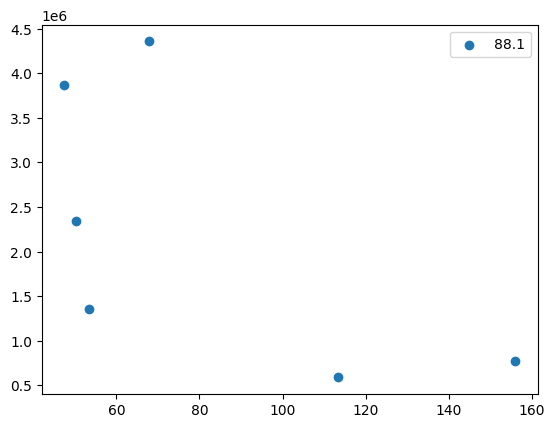

In [535]:
# Concatenate all dataframes from one quarter for clustering:
quarter = "FQ22018"
dataframes = []
for industry_cluster in range(1,165):
    dataframes.append(cluster_dataframes[quarter][industry_cluster])
concatenated_df = pd.concat(dataframes)

# Getting unique labels
# To print all labels:
u_labels = np.unique(concatenated_df["Industry Cluster"].astype(str))

# To print one certain industry
u_labels = ["88.1"]

# The x and y axis of the diagram:
axes = ["EV/EBIT","Total Revenue ($000)"]

# Plotting the results
for j in u_labels:
    plt.scatter(concatenated_df.loc[concatenated_df["Industry Cluster"] == j, axes[0]], concatenated_df.loc[concatenated_df["Industry Cluster"] == j, axes[1]], label=j)
plt.legend()
plt.show()
